In [4]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import tensorflow as tf
from datetime import datetime, timedelta, timezone
from keras import backend as ke
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from util import load_img

In [171]:
np.random.seed(0)

(x_train, y_train), (X_test, Y_test) = mnist.load_data()
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2)


# ------------------------------------------------------------------------------------------------------------
# 画像データ(教師データ、検証データ)のリシェイプ
# ------------------------------------------------------------------------------------------------------------
img_rows, img_cols = 28, 28
if ke.image_data_format() == 'channels_last':
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
else:
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)

# 配列の整形と、色の範囲を0～255 → 0～1に変換
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_valid /= 255
X_test /= 255


# ------------------------------------------------------------------------------------------------------------
# ラベルデータ(教師データ、検証データ)のベクトル化
# ------------------------------------------------------------------------------------------------------------
Y_train = np_utils.to_categorical(Y_train)      # 教師ラベルのベクトル化
Y_valid = np_utils.to_categorical(Y_valid)      # 検証ラベルのベクトル化
Y_test = np_utils.to_categorical(Y_test)        # テストラベルのベクトル化


# ------------------------------------------------------------------------------------------------------------
# ネットワークの定義 (keras)
# ------------------------------------------------------------------------------------------------------------
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(28,28,1), padding='same'))
BatchNormalization(axis=-1)
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
BatchNormalization(axis=-1)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), padding='same'))
BatchNormalization(axis=-1)
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
BatchNormalization(axis=-1)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(128, (3, 3), padding='same'))
BatchNormalization(axis=-1)
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# コンパイル
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# model表示
model.summary()

# CallBack設定
logdir = os.path.join("logs", datetime.now(timezone(timedelta(hours=+9), 'JST')).strftime("%Y%m%d-%H%M%S"))
if tf.io.gfile.exists("logs"):
    shutil.rmtree("logs")

callback_func1 = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_graph=True, write_images=False)
callback_func2 = ModelCheckpoint(filepath='weights.hdf5', verbose=0, save_best_only=True)

callbacks = []
callbacks.append(callback_func1)
callbacks.append(callback_func2)

# ImageDataGenerator設定
# https://keras.io/ja/preprocessing/image/#imagedatagenerator
GenTrain = ImageDataGenerator(
    featurewise_center=False,               # データセット全体で,入力の平均を0に調整
    samplewise_center=False,                # 各サンプルの平均を0に調整
    featurewise_std_normalization=False,    # 入力をデータセットの標準偏差で正規化
    samplewise_std_normalization=False,     # 各入力をその標準偏差で正規化
    zca_whitening=False,                    # ZCA白色化のイプシロン
    rotation_range=50,                      # 回転角度(-50～50度)
    width_shift_range=0.3,                  # 左右のスライド幅
    height_shift_range=0.2,                 # 上下のスライド幅
    zoom_range=[1.0,1.5],                   # 拡大・縮小率
    horizontal_flip=False,                  # 水平反転しない
    vertical_flip=False)                    # 垂直反転しない
GenTrain.fit(X_train)

GenValid = ImageDataGenerator(
    featurewise_center=False,               # データセット全体で,入力の平均を0に調整
    samplewise_center=False,                # 各サンプルの平均を0に調整
    featurewise_std_normalization=False,    # 入力をデータセットの標準偏差で正規化
    samplewise_std_normalization=False,     # 各入力をその標準偏差で正規化
    zca_whitening=False,                    # ZCA白色化のイプシロン
    rotation_range=50,                      # 回転角度(-50～50度)
    width_shift_range=0.3,                  # 左右のズレ幅
    height_shift_range=0.2,                 # 上下のズレ幅
    zoom_range=[1.0,1.5],                   # 拡大・縮小率
    horizontal_flip=False,                  # 水平反転しない
    vertical_flip=False)                    # 垂直反転しない
GenValid.fit(X_valid)

# ハイパーパラメータ設定
#          [sample]   [iteration]   [batch size]
# Train ： 48,000   / 100         = 480
# Varid ： 20,000   / 100         = 200
epochs = 200
iteration_train = 100
iteration_valid = 100
batch_size_train = int(X_train.shape[0] / iteration_train)
batch_size_valid = int(X_valid.shape[0] / iteration_valid)

# ImageDataGenerator.flow
# https://keras.io/ja/preprocessing/image/#flow
gen_train_flow = GenTrain.flow(X_train, Y_train, batch_size=batch_size_train)
gen_valid_flow = GenValid.flow(X_valid, Y_valid, batch_size=batch_size_valid)

# model fit
# https://keras.io/ja/models/model/#fit
history = model.fit(gen_train_flow,
                    steps_per_epoch=iteration_train,
                    epochs=epochs,
                    validation_data=gen_valid_flow,
                    validation_steps=iteration_valid,
                    callbacks=callbacks)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 activation (Activation)     (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                      

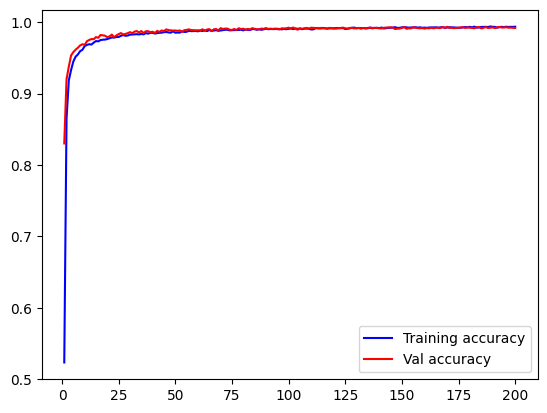

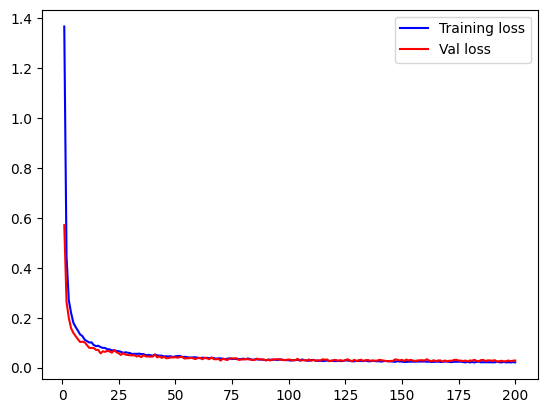

In [172]:
# print(history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_range = range(1, len(acc)+1)
plt.plot(epoch_range, acc, 'b', label='Training accuracy')
plt.plot(epoch_range, val_acc, 'r', label='Val accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(1, len(loss)+1 )
plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Val loss')
plt.legend()
plt.show()

In [201]:
model.save("../work/model")

INFO:tensorflow:Assets written to: ../work/model/assets


INFO:tensorflow:Assets written to: ../work/model/assets


In [5]:
reconstructed_model = keras.models.load_model("../work/model")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [6]:
reconstructed_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 activation (Activation)     (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                      

In [8]:
filename = '../image/slide/trimmed/0016/0016_000.jpg'
image = load_img(filename)
image = image.reshape(1, 28, 28)
pred = reconstructed_model.predict(image).argmax()
# pred = model.predict(np.array([x_test[99]])).argmax()
print(pred)

1/1 [==============================] - 0s 14ms/step
9
